# 손글씨 분류기 모델 학습

In [10]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import random
import os
import gc
import sys

import torch
import torchvision.transforms as T
import timm

import tensorflow as tf

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Data

In [3]:
(train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.mnist.load_data()

print(len(train_images), len(train_labels))
print(len(val_images), len(val_labels))

60000 60000
10000 10000


# Custom Dataset class

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        self.data = list((transforms(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]

        return image, label

In [5]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.7, 1.0)),  # 10% 내에서 이동
    # T.RandomResizedCrop(size=28, scale=(0.5, 1.0)),  # 크기 조정 및 자르기
    T.RandomRotation(degrees=20) # 20도 범위 내에서 회전
])

transforms = T.Compose([
    T.ToTensor()
])

train_dataset = CustomDataset(train_images, train_labels, aug_transforms)
valid_dataset = CustomDataset(val_images, val_labels, transforms)

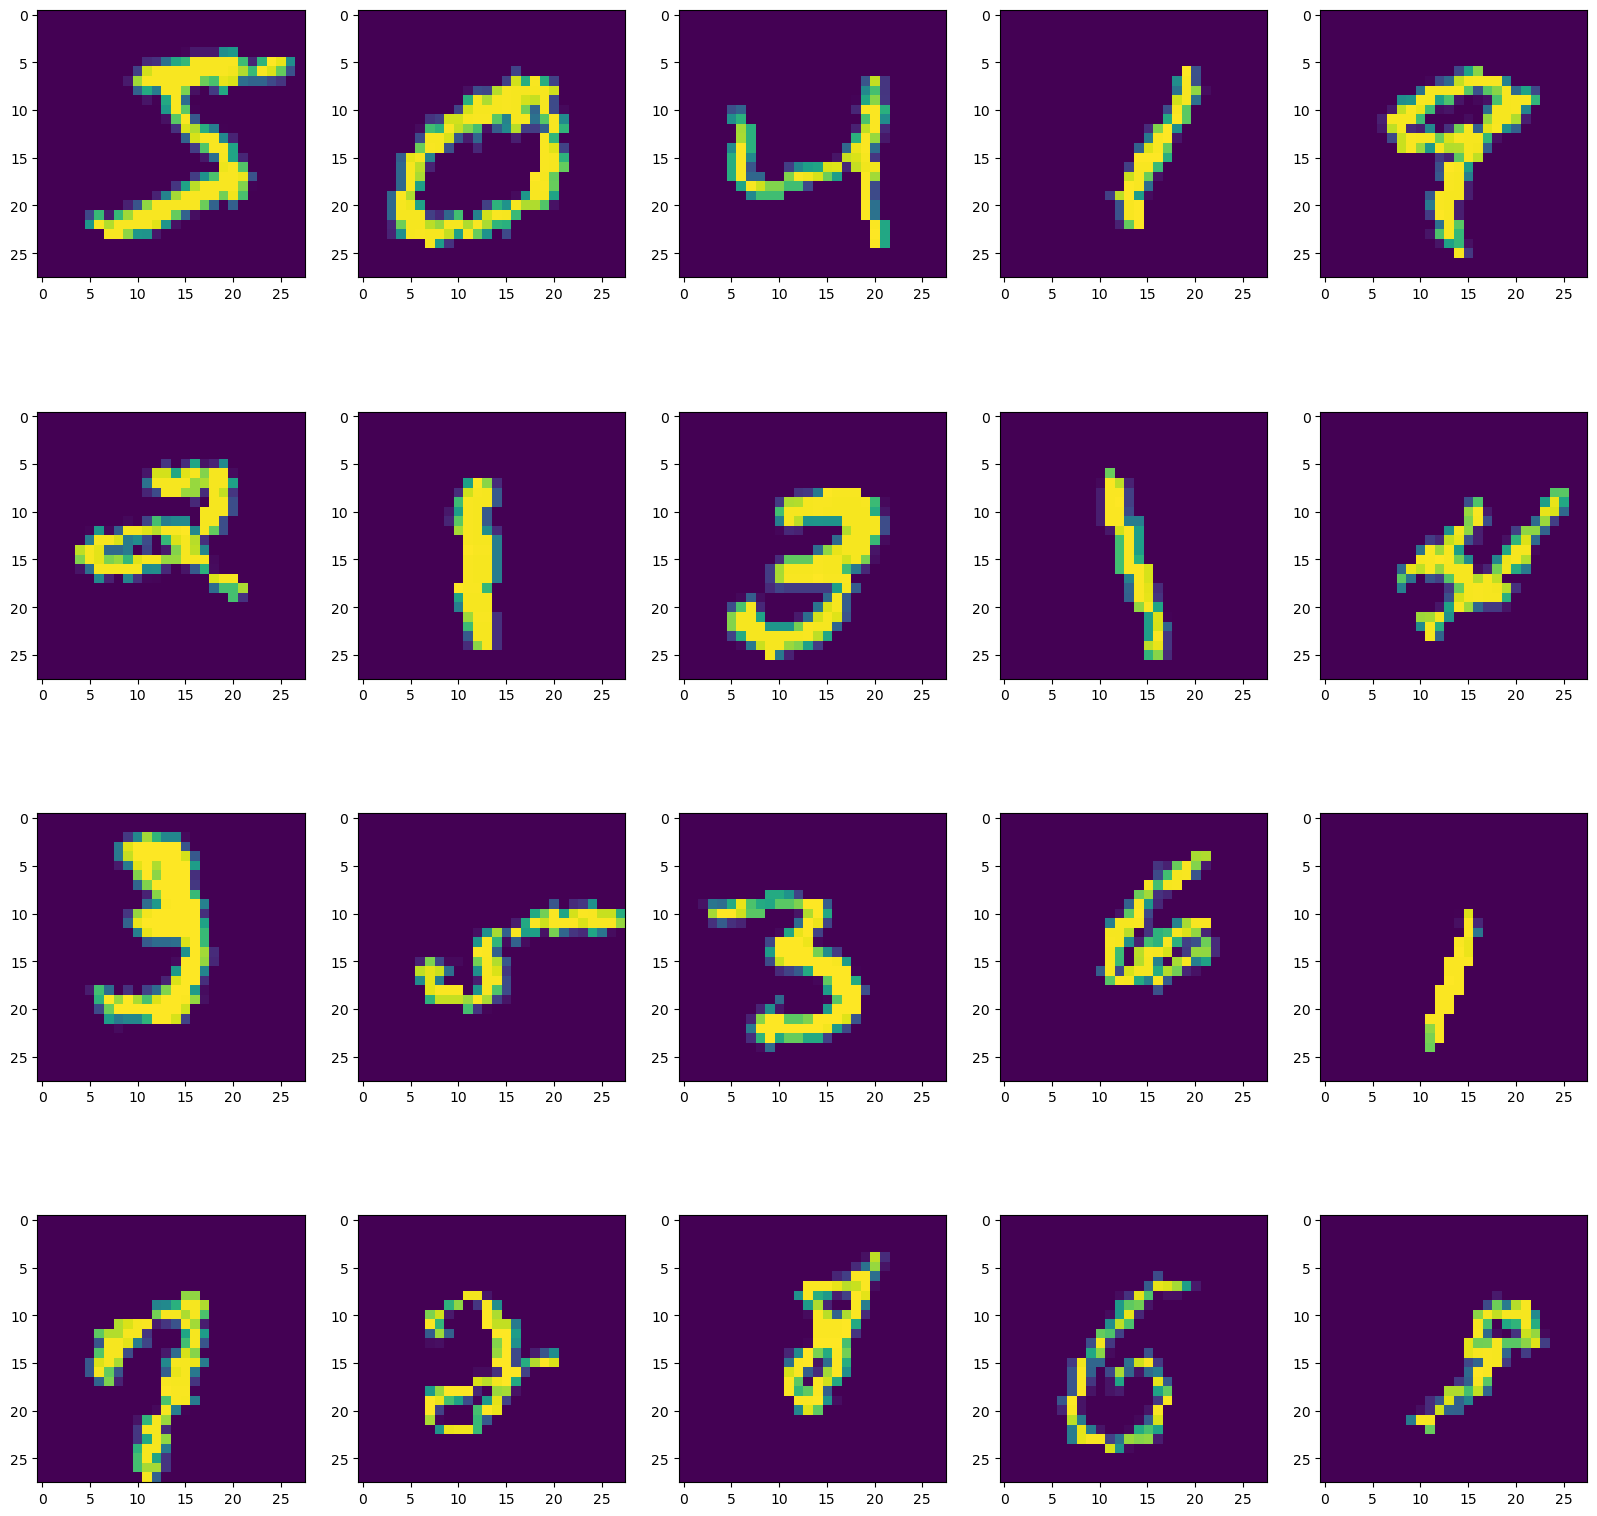

In [6]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))

# DataLoader

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=80, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=80, shuffle=False)

# Model

In [8]:
model = timm.create_model(
    'resnet18',
    in_chans=1,
    num_classes=10,
    pretrained=True
)

model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

# Train, Eval 함수

In [11]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_accuracy = 0
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(probs, 1)
        train_accuracy += (labels == predicted).sum().item()

        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_accuracy = 0
    valid_loss = 0.0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(probs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []
    min_valid_loss = sys.maxsize

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)

        if min_valid_loss > valid_loss:
            best_model = model

    return best_model, model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

# Model train

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_model, last_model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 30)

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.28933908243849876, Train Accuracy: 0.9127833333333333, Valid Loss: 0.04861672214278951, Valid Accuracy: 0.9843


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.12849665960545342, Train Accuracy: 0.9610333333333333, Valid Loss: 0.05131322027044371, Valid Accuracy: 0.983


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.09642538746198018, Train Accuracy: 0.9697666666666667, Valid Loss: 0.09150384475616738, Valid Accuracy: 0.9739


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.08331228786877667, Train Accuracy: 0.9745, Valid Loss: 0.03388202849309892, Valid Accuracy: 0.9898


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.07564936847472563, Train Accuracy: 0.9776666666666667, Valid Loss: 0.030729922850849106, Valid Accuracy: 0.991


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.06332135432912037, Train Accuracy: 0.9799, Valid Loss: 0.028096103333518842, Valid Accuracy: 0.992


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.055518562094618876, Train Accuracy: 0.9832833333333333, Valid Loss: 0.037767915668315256, Valid Accuracy: 0.9895


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.050524854685179886, Train Accuracy: 0.9841166666666666, Valid Loss: 0.021675104335998185, Valid Accuracy: 0.9933


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.05730942074038709, Train Accuracy: 0.9832666666666666, Valid Loss: 0.03274992837582249, Valid Accuracy: 0.9897


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.12048757745791226, Train Accuracy: 0.9693333333333334, Valid Loss: 0.029281544070574456, Valid Accuracy: 0.9903


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.04376470444793813, Train Accuracy: 0.9863833333333333, Valid Loss: 0.019416469163705187, Valid Accuracy: 0.9936


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.03254454390836569, Train Accuracy: 0.9897166666666667, Valid Loss: 0.025208217201201477, Valid Accuracy: 0.9928


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.04244955716282129, Train Accuracy: 0.9869666666666667, Valid Loss: 0.031904213773901575, Valid Accuracy: 0.9914


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.03657034825130055, Train Accuracy: 0.98815, Valid Loss: 0.02413973667616119, Valid Accuracy: 0.9936


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.026145348700946973, Train Accuracy: 0.9920166666666667, Valid Loss: 0.027446068840537918, Valid Accuracy: 0.9921


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.025803483278645824, Train Accuracy: 0.9917333333333334, Valid Loss: 0.03117036861491215, Valid Accuracy: 0.9917


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.050991608187304034, Train Accuracy: 0.9870833333333333, Valid Loss: 0.02275417477501833, Valid Accuracy: 0.9934


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.021425462807295844, Train Accuracy: 0.9931, Valid Loss: 0.021184333962784876, Valid Accuracy: 0.9937


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.019519044459584012, Train Accuracy: 0.9938666666666667, Valid Loss: 0.03096512778068427, Valid Accuracy: 0.9918


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.02616511727528026, Train Accuracy: 0.99285, Valid Loss: 0.02352439925380895, Valid Accuracy: 0.9938


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.01876449325074403, Train Accuracy: 0.99405, Valid Loss: 0.048040633320459165, Valid Accuracy: 0.9878


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.020011674200436876, Train Accuracy: 0.9933, Valid Loss: 0.03259033289936451, Valid Accuracy: 0.9928


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.017582320887508104, Train Accuracy: 0.9943, Valid Loss: 0.0387092323930865, Valid Accuracy: 0.9913


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.018123676806707713, Train Accuracy: 0.9939166666666667, Valid Loss: 0.028678695788324604, Valid Accuracy: 0.9936


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.02580486134882085, Train Accuracy: 0.9931333333333333, Valid Loss: 0.026249076945179695, Valid Accuracy: 0.993


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.013743317516086487, Train Accuracy: 0.99595, Valid Loss: 0.030965162656836697, Valid Accuracy: 0.9939


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.011391876567654738, Train Accuracy: 0.9967666666666667, Valid Loss: 0.0497718126939144, Valid Accuracy: 0.9893


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.016260755370106683, Train Accuracy: 0.9946833333333334, Valid Loss: 0.030916682214032334, Valid Accuracy: 0.9932


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.014792502965358532, Train Accuracy: 0.99575, Valid Loss: 0.025694759916974362, Valid Accuracy: 0.9933


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.012640753618899908, Train Accuracy: 0.99605, Valid Loss: 0.029113063291353682, Valid Accuracy: 0.9932


In [13]:
torch.save(best_model.state_dict(), 'resnet18_mnist_epochs_30_best_model.pth')
torch.save(last_model.state_dict(), 'resnet18_mnist_epochs_30_last_model.pth')

In [ ]:
model = timm.create_model(
    'resnet18',
    in_chans=1,
    num_classes=10,
    pretrained=False
)
model.load_state_dict(torch.load('resnet18_mnist_model.pth'))
model

# 입력한 이미지로 예측

In [ ]:
from PyQt5.QtWidgets import QApplication, QWidget, QPushButton, QVBoxLayout, QFileDialog
from PyQt5.QtGui import QPainter, QPen, QPixmap
from PyQt5.QtCore import Qt
import sys

class DrawBoard(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        self.setWindowTitle('Handwriting Input')
        self.setFixedSize(280, 280)
        self.image = QPixmap(self.size())
        self.image.fill(Qt.black)

        # 버튼들 추가
        clear_btn = QPushButton('Clear', self)
        clear_btn.clicked.connect(self.clear)
        
        save_btn = QPushButton('Save', self)
        save_btn.clicked.connect(self.save_image)

        layout = QVBoxLayout()
        layout.addWidget(clear_btn)
        layout.addWidget(save_btn)
        self.setLayout(layout)

    def paintEvent(self, event):
        canvasPainter = QPainter(self)
        canvasPainter.drawPixmap(self.rect(), self.image)

    def mouseMoveEvent(self, event):
        if event.buttons() == Qt.LeftButton:
            painter = QPainter(self.image)
            pen = QPen(Qt.white, 20, Qt.SolidLine)
            painter.setPen(pen)
            painter.drawPoint(event.pos())
            self.update()

    def clear(self):
        self.image.fill(Qt.white)
        self.update()

    def save_image(self):
        # 파일 저장 대화상자 열기
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getSaveFileName(self, "Save Image", "", "PNG Files (*.png);;All Files (*)", options=options)
        
        if file_name:
            self.image.save(file_name)
            print(f"이미지가 저장되었습니다: {file_name}")

app = QApplication(sys.argv)
window = DrawBoard()
window.show()
sys.exit(app.exec_())

In [ ]:
# 직접 만든 손글씨 이미지로 테스트

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, images, transforms):
        self.root = root_dir
        self.data = images
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.data[idx])
        img = Image.open(img_path).convert("L")
        img = self.transforms(img)
        return img

In [ ]:
root_dir = 'input_images'
images = os.listdir(root_dir)

test_transforms = T.Compose([
    T.Resize((28, 28)),
    T.ToTensor()
])

test_dataset = TestDataset(root_dir, images, test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=80, shuffle=False)

In [ ]:
model.to(device)
model.eval()
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images in tbar:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)

        total_preds.extend(preds)

print(total_preds)

In [ ]:
model.eval()
total_preds = []
test_accuracy = 0

with torch.no_grad():
    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)
        test_accuracy += (labels == preds).sum().item()

        total_preds.extend(preds)

print(test_accuracy/len(valid_dataloader))